In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Auto.csv")
data = pd.DataFrame(data)
print(data.shape)
data.head()

(397, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


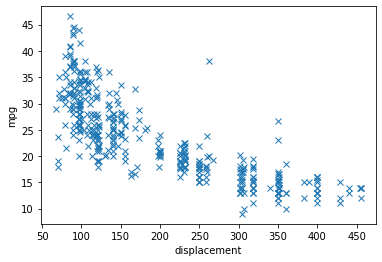

In [3]:
plt.plot(data['displacement'], data['mpg'], 'x')
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.show()

In [4]:
# we can see in the first figure their are outliers 
# removing values that have displacement > 250 and mpg >25 
for i,j in zip(data['displacement'], data['mpg']):
    if i>250 and j > 25:
        break

a = data[data["displacement"] > 250].index.values

b = data[data["mpg"] > 25].index.values

data = data.drop(np.intersect1d(a,b))

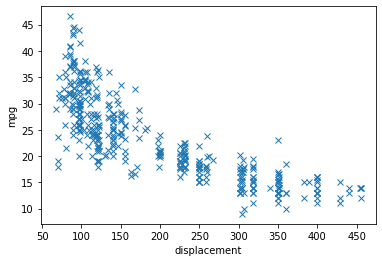

In [5]:
# hence the outliers are now removed
plt.plot(data['displacement'], data['mpg'], 'x')
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.show()

In [6]:
def normalize(vec):
    """ min max scaling to limit data to 0-1 range
    
    normalize = (xi - min(x))/(max(x) - min(x))
    """
    
    for j in range(vec.shape[1]):
        vec[:, j] = np.array([(i - min(vec[:, j]))/(max(vec[:, j])-min(vec[:, j])) for i in vec[:, j]])
    
    return vec

### Predicting Miles per gallon based on Displacement of the vehicle

In [7]:
# creating training and test set
data_np = np.array(data.sample(frac=1))

train_input = np.float32(data_np[0:int(len(data_np)*0.75), [2,4]])
train_output = np.float32(data_np[0:int(len(data_np)*0.75), 0:1])

test_input = np.float32(data_np[int(len(data_np)*0.75):, [2,4]])
test_output = np.float32(data_np[int(len(data_np)*0.75):, 0:1])

# normalize the dataset
train_input = normalize(train_input)
test_input = normalize(test_input)

train_output = normalize(train_output)
test_output = normalize(test_output)

print("train inputs: ", train_input.shape)
print("train outputs: ", train_output.shape)
print("test inputs: ", test_input.shape)
print("test outputs: ", test_output.shape)

train inputs:  (296, 2)
train outputs:  (296, 1)
test inputs:  (99, 2)
test outputs:  (99, 1)


In [8]:
# using least squares model

# displacement
x = train_input[:, 0:1].reshape(len(train_input),1)

# x mean
x_mean = np.mean(x)

# y mean
y_mean = np.mean(train_output)


# coefficient of displacment
xi_minus_x_mean = np.array([i-x_mean for i in x])
yi_minus_y_mean = np.array([i-y_mean for i in train_output])
b1 = np.sum( np.multiply(xi_minus_x_mean, yi_minus_y_mean) ) / np.sum(np.square(xi_minus_x_mean))

# intercept
b0 = y_mean - b1*x_mean


# linear equation for predicting mpg
y_hat = b0 + b1*(x)

This is a linear fit. We can notice that the line does not fit very well with the data


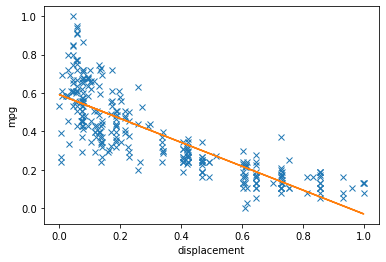

In [9]:
print("This is a linear fit. We can notice that the line does not fit very well with the data")
plt.plot(train_input[:, 0], train_output, 'x')
plt.plot(train_input[:, 0], y_hat, '-')
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.show()

### 1. Now we will use optimization to minimize the Mean Squared Error of a logarithmic Equation
### 2. will also use weight of the vhivle as a predictor

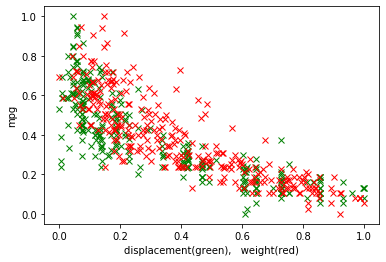

In [10]:
plt.plot(train_input[:, 0], train_output, 'xg')
plt.plot(train_input[:, 1], train_output, 'xr')
plt.xlabel("displacement(green),   weight(red)")
plt.ylabel("mpg")
plt.show()

In [11]:
def y_hat_log(w1,w2,b0,x):
    """ returns the result of the logarithmic equation y = w1.ln(x) + w2.x + b0

    w1, w2 are slopes
    b0 is the intercept
    x is the input data
    
    """
    return np.dot(np.log(x+1e-10), w1) + np.dot(x, w2) + b0


def MSE(g_truth, pred):
    """ Calculate Mean Squared Error
    
    g_truth: actual value of mpg
    pred: predicted mpg
    """
       
    return (0.5)*np.mean(np.square(g_truth-pred))

In [12]:
# weight initialisation
m1 = np.zeros((2, 1),dtype=np.float32)
m2 = np.zeros((2, 1),dtype=np.float32)
b  = np.zeros((1, 1),dtype=np.float32)

loss = []
epochs = 10000
# learning rate
lr = 0.008
# length of training set
m_tr = len(train_input)

for i in range(epochs):
    # calculate y_hat for entire dataset
    y_quad = y_hat_log(m1,m2,b,train_input)
    
    # run gradient descent optimizer
    # d(mse)/dm1 = d(mse)/dy_hat * d(y_hat)/d(m1)
    d_mse = y_quad-train_output
    
    d_mse_dm1 = np.dot(d_mse.T, np.log(train_input+1e-10))
    
    # d(mse)/dm1 = d(mse)/dy_hat * d(y_hat)/d(m2)
    d_mse_dm2 = np.dot(d_mse.T, train_input)
    
    ## d(mse)/db = d(mse)/dy_hat * d(y_hat)/d(b)
    d_mse_db = np.sum(d_mse)
    

    # updating slope and intercept
    m1 = m1 - (lr/m_tr) * d_mse_dm1.T
    m2 = m2 - (lr/m_tr) * d_mse_dm2.T
    b = b - (lr/m_tr) * d_mse_db
    
    loss.append(MSE(train_output, y_quad))

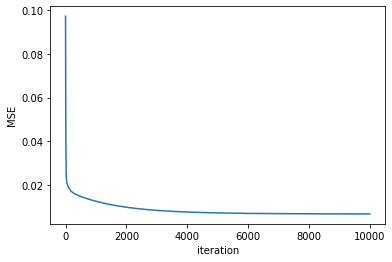

In [13]:
plt.plot(range(epochs), loss, '-')
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.show()

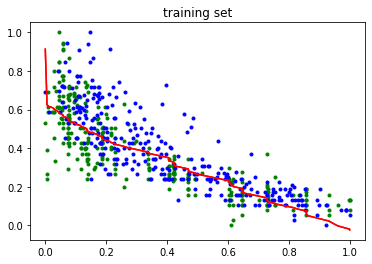

In [14]:
# sorting the predicted fit
train_input_sorted = np.sort(train_input, axis=0)
y_hat_sorted = y_hat_log(m1,m2,b,train_input_sorted)

plt.plot(train_input[:,0],train_output, '.g')
plt.plot(train_input[:,1],train_output, '.b')
plt.plot(train_input_sorted[:,0], y_hat_sorted, '-r')
plt.plot(train_input_sorted[:,0], y_hat_sorted, '-r')
plt.title("training set")
plt.show()

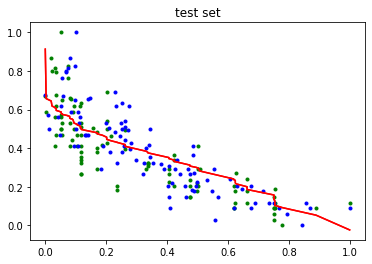

In [15]:
# test set
test_input_sorted = np.sort(test_input, axis=0)
y_hat_sorted_test = y_hat_log(m1,m2,b,test_input_sorted)

plt.plot(test_input[:,0],test_output, '.g')
plt.plot(test_input[:,1],test_output, '.b')
plt.plot(test_input_sorted[:,0], y_hat_sorted_test, '-r')
plt.plot(test_input_sorted[:,0], y_hat_sorted_test, '-r')
plt.title("test set")
plt.show()

So far I've tried the following equations for fitting the line

* $\hat y = m_1x^2 + m_2x + b$
* $\hat y = m_1 \sqrt x + m_2x + b$
* $\hat y = m_1\ln (x) + m_2x + b$

among these the 3rd equation had the best fit

Also, the weights were initialised with zeros which gave a better fit than sampling from normal distribution

~~~This is not the best fit as can be seen, therefore, suggestions are always welcome~